# Một cách tiếp cận sử dụng LSTM

Xem phần phân tích cụ thể và tiền xử lí trong file PJ3.ipynb

## 1. Đọc dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn 
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader

c:\Users\Nam\miniconda3\envs\torch-coding\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/vn_news_223_tdlfr.csv')
df.drop(columns=['domain'],inplace=True)
df

,text,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",1
...,...,...
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,0
219,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,0
220,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,0
221,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,0


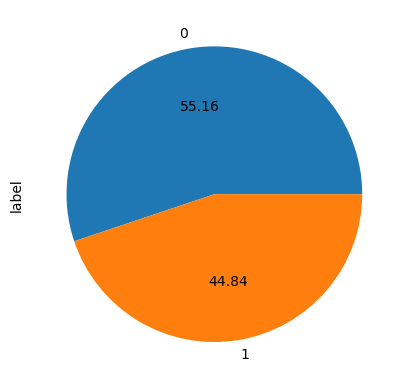

In [3]:
df.label.value_counts().plot(kind='pie', autopct='%.2f');

## Tiền xử lí

Vì dữ liệu nhỏ nên sẽ không có tập val

In [4]:
X_df = df.drop('label', axis=1)
y_df = df['label']
x_train, x_test, y_train, y_test = train_test_split(X_df, 
                                                    y_df, 
                                                    test_size=0.2,
                                                    stratify = y_df, 
                                                    random_state=42)

In [5]:
def preprocess(s):
    s = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})', '', s)
    s = re.sub(r'[^\w\s]',' ', s)
    s = re.sub(r'\d', ' ', s)
    s = re.sub(r'\s+', ' ',s)
    return s

In [6]:
with open('stopwords/vietnamese-stopwords.txt',encoding='utf-8') as f:
    stopwords = f.readlines()
    stopwords = [word.rstrip() for word in stopwords]

Tokenize các văn bản và padding. Chiều dài tối đa là 1000

In [7]:
def tokenizer(x_train, y_train, x_val, y_val, stop_words):
    word_list = list()
    for sequence in x_train:
        for word in sequence.lower().split():
            word = preprocess(word)
            if word not in stop_words and word !='':
                word_list.append(word)
    
    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)#[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train, final_list_test = list(), list()
    for sequence in x_train:
        final_list_train.append([onehot_dict[preprocess(word)] for word in sequence.lower().split()
                                if preprocess(word) in onehot_dict.keys()])
    for sequence in x_val:
        final_list_test.append([onehot_dict[preprocess(word)] for word in sequence.lower().split()
                              if preprocess(word) in onehot_dict.keys()])
    return (np.array(final_list_train, dtype='object'), 
            np.array(y_train), 
            np.array(final_list_test, dtype='object'), 
            np.array(y_val), 
            onehot_dict)

In [8]:
x_train, y_train, x_test, y_test, vocab = tokenizer(x_train.text.to_list(), 
                                             y_train, 
                                             x_test.text.to_list(), 
                                             y_test, 
                                             stopwords)

In [9]:
print(f'Length of vocab: {len(vocab)}')

Length of vocab: 5704


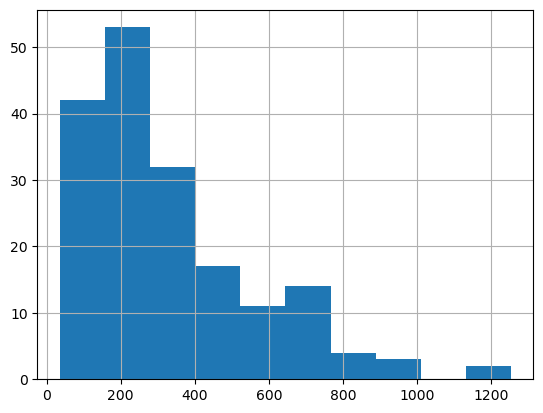

count     178.000000
mean      335.516854
std       233.938937
min        36.000000
25%       162.500000
50%       257.500000
75%       424.000000
max      1254.000000
dtype: float64

In [10]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [11]:
MAX_LEN = 1000
BATCH_SIZE = 32
n_layers = 2
vocab_size = len(vocab) + 1
output_dims = 1
hidden_dims = 64
embedding_dims = 64

In [12]:
def padding(X, max_len):
    features = np.zeros((len(X), max_len),dtype=int)
    for i, sequence in enumerate(X):
        features[i, -len(sequence):] = np.array(sequence)[:max_len]
    return features
x_train_padding = padding(x_train, MAX_LEN)
x_test_padding = padding(x_test, MAX_LEN)

In [13]:
train_data = TensorDataset(torch.from_numpy(x_train_padding), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_padding), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE)

In [14]:
len(test_dataloader.dataset)

45

In [15]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device('cuda')
    print('GPU available')
else:
    device = torch.device('cpu')
    print('CPU available')

GPU available


## Mô hình LSTM bằng PyTorch

In [16]:
class LSTM(nn.Module):
    def __init__(self, n_layers, vocab_size, hidden_dims, embedding_dims, dropout_rate = 0.5):
        super(LSTM, self).__init__()
        self.output_dims = output_dims
        self.hidden_dims = hidden_dims
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(self.vocab_size, embedding_dims)
        self.lstm = nn.LSTM(input_size = embedding_dims,
                           hidden_size = self.hidden_dims,
                           num_layers = self.n_layers,
                           batch_first = True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.hidden_dims, self.output_dims)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        batch_size = x.size(0)
        embedding = self.embedding(x)
        lstm_out, hidden_state = self.lstm(embedding)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dims)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, -1)
        out = out[:, -1]
        return out, hidden_state
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dims)).to(device)
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dims)).to(device)
        return (h0, c0)

In [17]:
model = LSTM(n_layers, vocab_size, hidden_dims, embedding_dims)
model.to(device)

LSTM(
  (embedding): Embedding(5705, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─Embedding: 1-1                         365,120
├─LSTM: 1-2                              66,560
├─Dropout: 1-3                           --
├─Linear: 1-4                            65
├─Sigmoid: 1-5                           --
Total params: 431,745
Trainable params: 431,745
Non-trainable params: 0

In [19]:
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
def accuracy(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred==label.squeeze()).item()

In [20]:
clip = 5
EPOCHS = 30
valid_loss_min = np.Inf

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}
train_step = len(train_dataloader.dataset) // BATCH_SIZE
test_step = len(test_dataloader.dataset) // BATCH_SIZE

start_time = time.time()
for epoch in range(EPOCHS):
    train_loss = list()
    train_acc = 0
    model.train()
    hidden_state = model.init_hidden(BATCH_SIZE)
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        hidden_state = tuple([each.data for each in hidden_state])
        # print(inputs.shape, hidden_state)
        
        model.zero_grad()
        output, hidden_state = model(inputs)#, hidden_state)
        
        loss = loss_fn(output.squeeze(), labels.float())
        loss.backward()
        
        train_loss.append(loss.item())
        
        acc = accuracy(output, labels)
        train_acc += acc
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    test_h = model.init_hidden(BATCH_SIZE)
    test_loss = list()
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_dataloader:
            test_h = tuple([each.data for each in test_h])

            inputs, labels = inputs.to(device), labels.to(device)
            output, test_h = model(inputs)

            loss = loss_fn(output.squeeze(), labels.float())
            test_loss.append(loss.item())

            acc = accuracy(output, labels)
            test_acc += acc
    
    epoch_train_loss = np.mean(train_loss)
    epoch_test_loss = np.mean(test_loss)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)#(train_step * BATCH_SIZE)
    epoch_test_acc = test_acc/len(test_dataloader.dataset)#(test_step * BATCH_SIZE)
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    history['train_acc'].append(epoch_train_acc)
    history['test_acc'].append(epoch_test_acc)
    
    print(f'[INFO] EPOCHS: {epoch + 1}/{EPOCHS}')
    print('Train loss: {:.6f}, Test loss: {:.6f}'.format(epoch_train_loss,epoch_test_loss))
    print('Train acc: {:.4f}, Test acc: {:.4f}\n'.format(epoch_train_acc,epoch_test_acc))    

end_time = time.time()
print('[INFO] total time taken to train the model: {:.2f}s'.format(end_time - start_time))

[INFO] EPOCHS: 1/30
Train loss: 0.692817, Test loss: 0.687019
Train acc: 0.5449, Test acc: 0.5556

[INFO] EPOCHS: 2/30
Train loss: 0.687388, Test loss: 0.685260
Train acc: 0.5506, Test acc: 0.5556

[INFO] EPOCHS: 3/30
Train loss: 0.681215, Test loss: 0.683211
Train acc: 0.5562, Test acc: 0.5556

[INFO] EPOCHS: 4/30
Train loss: 0.678689, Test loss: 0.679970
Train acc: 0.5506, Test acc: 0.5556

[INFO] EPOCHS: 5/30
Train loss: 0.667642, Test loss: 0.674256
Train acc: 0.5674, Test acc: 0.5556

[INFO] EPOCHS: 6/30
Train loss: 0.647623, Test loss: 0.662841
Train acc: 0.5955, Test acc: 0.5556

[INFO] EPOCHS: 7/30
Train loss: 0.613051, Test loss: 0.635632
Train acc: 0.6348, Test acc: 0.5778

[INFO] EPOCHS: 8/30
Train loss: 0.559825, Test loss: 0.590961
Train acc: 0.7247, Test acc: 0.6222

[INFO] EPOCHS: 9/30
Train loss: 0.460237, Test loss: 0.527789
Train acc: 0.8596, Test acc: 0.7333

[INFO] EPOCHS: 10/30
Train loss: 0.341116, Test loss: 0.485795
Train acc: 0.8933, Test acc: 0.7333

[INFO] EP

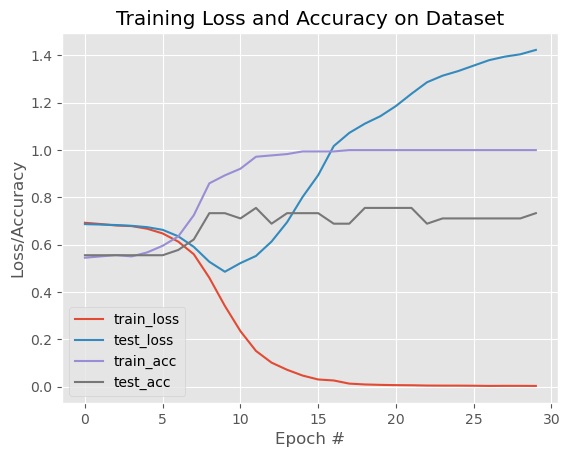

In [21]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left");

In [22]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess(word)] for word in text.split() 
                         if preprocess(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad = torch.from_numpy(padding(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs)
        return(output.item())

In [23]:
i = 0
print('Predict: ',predict_text(df.text[i]))
print('Actual: ',df.label[i])

Predict:  0.9971569776535034
Actual:  1


Mô hình bị overfitting???